In [ ]:

!ls /home/aistudio/data

data18746


In [ ]:

!unzip -oq -d  /home/aistudio/work/defectData /home/aistudio/data/data18746/NEU-DET.zip

In [41]:
# 导入相关库
import paddle
import os
import shutil
import random
import numpy as np
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import cv2
import time

# 项目背景

**深度学习在工业应用中具有重要意义。**

**本项目以工业中真实表面缺陷数据训练缺陷检测模型。**

**最近刚开始入门学习目标检测模型YOLO系列，结合[AI达人创造营](https://aistudio.baidu.com/aistudio/education/group/info/24607)的学习内容，学习全流程自己搭建深度学习模型。**

# 数据集介绍

数据来自AIstudio公开数据集：[NEU-DET](https://aistudio.baidu.com/aistudio/datasetdetail/18746)

数据集包含了热轧钢带的六种表面缺陷：**['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches']**

数据集包括 1800 张灰度图像：6 种不同类型的表面缺陷各有 300 个样本

![](https://ai-studio-static-online.cdn.bcebos.com/e1c021e1dc8145d4b8ed05541bbdc11f375c28d688fe40d49f45794a5b471aa6)

**缺陷特征不是很明显，而且不同的缺陷有些相似。**

In [39]:
# 获取缺陷名字
def get_defect_names(Dir_path,Images_Dir='IMAGES'):
    """
    return a list, as following,
        ['crazing',
         'inclusion',
         'patches',
         'pitted_surface',
         'rolled-in_scale',
         'scratches' ]
    """
    DEF_NAMES = []
    piclist = os.listdir(os.path.join(Dir_path, Images_Dir))
    for pic in piclist:
        picname = pic[0:pic.rfind("_")]
        if picname not in DEF_NAMES:
            DEF_NAMES.append(picname)

    return DEF_NAMES

f_Dir = 'work/defectData/NEU-DET'

DEF_NAMES = get_defect_names(f_Dir)
DEF_NAMES.sort()
print(DEF_NAMES)

['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches']


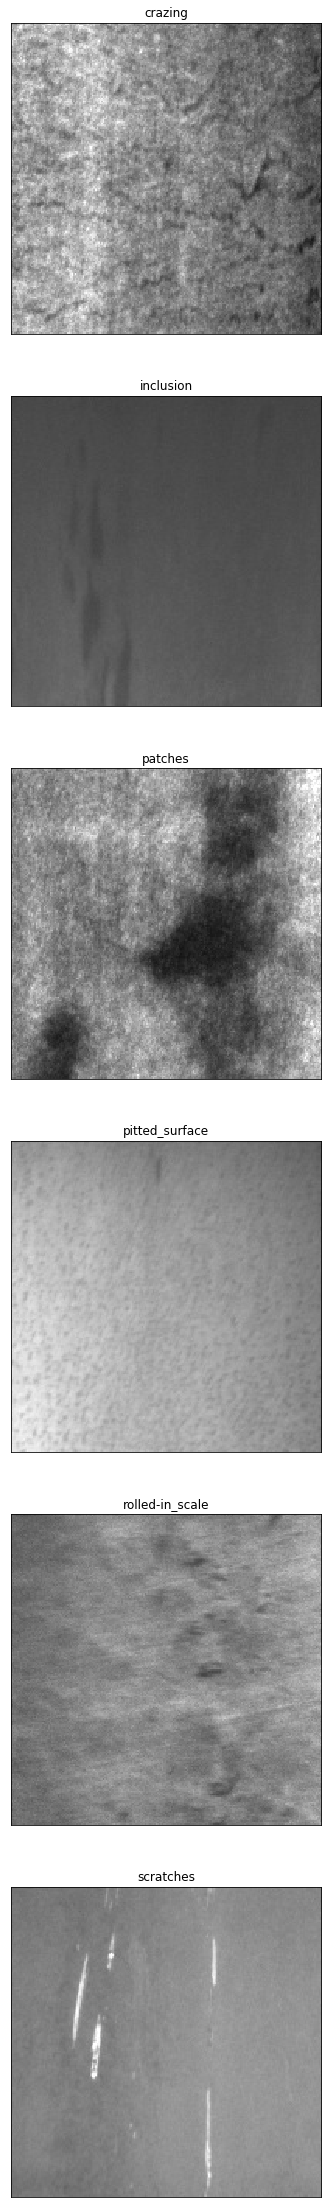

In [40]:
# 展示部分数据
def img_show(img, title='', cmap=None):
    fig = plt.imshow(img, interpolation='nearest', cmap=cmap)
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.title(title)

plt.figure(figsize=(40, 40))
for i in range(6):
    plt.subplot(6, 1, i + 1)
    fig = img_show(plt.imread(f'work/defectData/NEU-DET/IMAGES/{DEF_NAMES[i]}_{i+10}.jpg'), title=DEF_NAMES[i])

# 制作标签信息文档

首先转换原始标签信息，YOLO检测模型需要的真实框的标签信息是中心点坐标加宽高。

原始标签信息是左上角点坐标与右下角点坐标。

最后将信息保存在txt文档中。

如在labels文件夹下，有不同缺陷的标签数据。

**scratches_28.txt保存的是scratches_28.jpg的标签数据**

In [3]:
def convert(size, box):  # 转换标签信息
    """
    将bbox的左上角点、右下角点坐标的格式，转换为中心点x,y + 宽高w,h的格式
    size：图片宽w，高h
    box：真实框信息，包含左上角点坐标与右下角点坐标
    返回归一化后的中心点坐标与宽高
    """
    dw = 1. / size[0]
    dh = 1. / size[1]
    x = (box[0] + box[1]) / 2.0 # 计算中心点x坐标
    y = (box[2] + box[3]) / 2.0 # 计算中心点y坐标
    w = box[1] - box[0]
    h = box[3] - box[2]
    x = x * dw  # 归一化
    w = w * dw
    y = y * dh
    h = h * dh
    return (x, y, w, h)  # 全部都已经归一化

def convert_annotation(image_id,f_Dir,Annotations_Dir='ANNOTATIONS',labels_Dir='labels'): # 转换坐标信息后并写入txt文档中
    """
    把图像image_id的xml文件转换为目标检测需要的label文件(txt)

    文件中记录的信息包含  物体的类别，归一化后的bbox的中心点点坐标  以及bbox的宽、高
    """
    in_file = open(f_Dir + '/'+Annotations_Dir+'/%s' % (image_id))
    image_id = image_id.split('.')[0]
    out_file = open(f_Dir+'/'+labels_Dir+'/%s.txt' % (image_id), 'w')  #  labels文件夹需要提前创建好
    tree = ET.parse(in_file)
    root = tree.getroot()
    size = root.find('size')
    w = int(size.find('width').text)
    h = int(size.find('height').text)

    for obj in root.iter('object'):
        difficult = obj.find('difficult').text
        cls = obj.find('name').text
        if cls not in DEF_NAMES or int(difficult) == 1:
            continue
        cls_id = DEF_NAMES.index(cls)
        xmlbox = obj.find('bndbox')
        points = (float(xmlbox.find('xmin').text), float(xmlbox.find('xmax').text), float(xmlbox.find('ymin').text),
             float(xmlbox.find('ymax').text))
        bb = convert((w, h), points)
        out_file.write(str(cls_id) + " " + " ".join([str(a) for a in bb]) + '\n')  # 写入信息


def make_label_txt(Dir_path, Annotations_Dir='ANNOTATIONS'):
    """在labels文件夹下创建image_id.txt文件，对应每个image_id.xml提取出的bbox信息"""
    filenames = os.listdir(os.path.join(Dir_path, Annotations_Dir))
    for filename in filenames:
        convert_annotation(filename,Dir_path)



![](https://ai-studio-static-online.cdn.bcebos.com/9162012b14404f4b934bfd40b601259ecc39772e76c14930adc3addb593a4612)


In [ ]:
# 调用
make_label_txt(f_Dir)

In [4]:
def show_labels_img(img_id, img_Dir='work/defectData/NEU-DET/IMAGES'): 
    """imgname是输入图像的名称"""
    img = cv2.imread(img_Dir+ '/' + img_id + ".jpg") # 读取图像
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # 转换图像格式
    h, w = img.shape[:2] # 获取图像高宽
    print(w,h)
    label = []
    with open(f_Dir+"/labels/"+img_id+".txt",'r') as flabel: # 读取labels文件中的真实框信息
        for label in flabel:
            label = label.split(' ')
            label = [float(x.strip()) for x in label] # 读取后的信息为[11,0.332,0.588,0.12,0.09866666666666667] 都是归一化后的数值
            print(DEF_NAMES[int(label[0])]) # 获取类别信息
            pt1 = (int(label[1] * w - label[3] * w / 2), int(label[2] * h - label[4] * h / 2)) # 根据x,y,w,h，转换得到真实框的左上角点
            pt2 = (int(label[1] * w + label[3] * w / 2), int(label[2] * h + label[4] * h / 2)) # 根据x,y,w,h，转换得到真实框的右下角点
            cv2.putText(img,DEF_NAMES[int(label[0])],pt1,cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,255))
            cv2.rectangle(img,pt1,pt2,(0,0,255),2)
    plt.imshow(img)
    plt.show()

200 200
pitted_surface
patches
patches


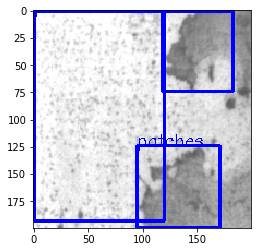

In [ ]:
# 查看标签信息可视化
show_labels_img('pitted_surface_276')

# 模型选择

已经有很多成熟的目标检测模型了，也有方便快速开发的套件[PaddleDetection](https://github.com/PaddlePaddle/PaddleDetection)

鉴于目前在学习YOLO网络，同时又有[AI达人创造营](https://aistudio.baidu.com/aistudio/education/group/info/24607)课程支持，便考虑自己搭建一个简单的目标检测模型。

**YOLOv2比YOLOv1要好，又比YOLOv3简单一些，搭建起来应该会快一点，于是选择YOLOv2模型。**

# 定义网络
## 网络结构

论文地址：[YOLO9000: Better, Faster, Stronger](https://arxiv.org/abs/1612.08242)

**YOLOv2的主干网络是 Darknet-19，在检测部分有一个passthrough层，这个层就是把Darknet-19中的3 × 3 × 512卷积层的输出拿出来，与最后第二个卷积层的输出进行通道上的融合。**

**下图是网络结构：**

![](https://ai-studio-static-online.cdn.bcebos.com/ebd881cf36bb4e84ae5e6db45804e381031dd1413afe4bd8a37f7aef5d1c4bfd)

## 搭建Darknet-19网络
**网络中使用的卷积层由三部分组成，分别是：Conv2D，Batch Normalization，LeakyReLU，可以先创建一个基础卷积类。**

In [5]:
import paddle
import paddle.nn as nn

class CBL(nn.Layer):
    def __init__(self,C_input,C_output):
        super(CBL, self).__init__()
        self.conv_layer = nn.Sequential( nn.Conv2D(C_input, C_output, 3,stride=1, padding="SAME", bias_attr=False),  
                                         nn.BatchNorm2D(C_output),
                                         nn.LeakyReLU(negative_slope=0.1))
    def forward(self, x):
        x = self.conv_layer(x)
        return x

class Darknet19(nn.Layer):
    def __init__(self):
        super(Darknet19, self).__init__()
        self.maxpool = nn.MaxPool2D(kernel_size=2, stride=2, padding=0)
        self.conv_layer1 = CBL(3,32)
        self.conv_layer2 = CBL(32,64)
        self.conv_layer3 = nn.Sequential(CBL(64,128),CBL(128,64),CBL(64,128))
        self.conv_layer4 = nn.Sequential(CBL(128,256),CBL(256,128),CBL(128,256))
        self.conv_layer5 = nn.Sequential(CBL(256,512),CBL(512,256),CBL(256,512),CBL(512,256),CBL(256,512))
        self.conv_layer6 = nn.Sequential(CBL(512,1024),CBL(1024,512),CBL(512,1024),CBL(1024,512),CBL(512,1024))
    def forward(self, x):
        x = self.conv_layer1(x)
        x = self.maxpool(x)
        x = self.conv_layer2(x)
        x = self.maxpool(x)
        x = self.conv_layer3(x)
        x = self.maxpool(x)
        x = self.conv_layer4(x)
        x = self.maxpool(x)
        feature = self.conv_layer5(x)  # 用于后面的passthrough层
        x = self.maxpool(feature)
        x = self.conv_layer6(x)
        return x,feature 

## 搭建detection网络

**detection网络中包括了passthrough层，此层将高分辨率特征与低分辨率特征在通道上进行叠加，用以融合Fine-Grained Features（细粒度特性）。**

In [6]:
# 定义检测网络
class Detection(nn.Layer):
    def __init__(self, num_anchor = 5, num_clas = 6, is_Conv = True):
        super(Detection, self).__init__()
        '''
        is_Conv：是否对feature进行通道缩减，如batchsize x 512 x 26 x26 --> batchsize x 64 x 26 x26
        '''
        self.num_anchor = num_anchor
        self.num_clas = num_clas
        self.is_conv = is_Conv
        self.conv_layer = CBL(1024,1024)
        self.conv_decrease_channel = CBL(512,64)
        self.passthrough = nn.Unfold([2, 2], strides=2, paddings=0)
        self.pred = nn.Conv2D(1024, self.num_anchor*(5+self.num_clas), (1, 1))  # 55=5*(5+6)
            
    def forward(self, x,feature):
        '''
        x：骨干网络Darknet19的最后输出特征图 batchsize x 1024 x 13 x13
        feature：用于进行特征融合的特征图 batchsize x 512 x 26 x26 
        '''
        x = self.conv_layer(x)  # 第一个Conv_layer
        x = self.conv_layer(x)  # 第二个Conv_layer
        # passthrough
        if self.is_conv:  
            feature = self.conv_decrease_channel(feature)
        # 数据重排
        _ , channel , h , w = feature.shape
        feature = self.passthrough(feature)
        feature = feature.reshape((-1, channel*4, h//2, w//2))
        # concatenates
        x = paddle.concat(x=[x, feature], axis=1)  

        x = CBL(x.shape[1],1024)(x)  # 第三个Conv_layer
        x = self.pred(x)
        return x

In [7]:
class YOLOv2(nn.Layer):
    def __init__(self,scale = 32, is_Conv=True):
        super(YOLOv2, self).__init__()
        '''
        scale: 缩放比例，如一张416x416大小的图片，经过缩放后，变为13x13的特征图。
        is_Conv：在passthrough层中，是否对feature进行通道缩减，如batchsize x 512 x 26 x26 --> batchsize x 64 x 26 x26
        '''
        self.darknet = Darknet19()
        self.detection = Detection(is_Conv=is_Conv)
    def forward(self,x):
        x,feature = self.darknet(x)
        x = self.detection(x,feature)
        return x 

In [ ]:
# 查看YOLOv2网络
net = YOLOv2()
params_info = paddle.summary(net, (1, 3, 416, 416))
print(params_info)

-------------------------------------------------------------------------------------------------------------
 Layer (type)                Input Shape                          Output Shape                  Param #    
   Conv2D-1              [[1, 3, 416, 416]]                     [1, 32, 416, 416]                 864      
 BatchNorm2D-1           [[1, 32, 416, 416]]                    [1, 32, 416, 416]                 128      
  LeakyReLU-1            [[1, 32, 416, 416]]                    [1, 32, 416, 416]                  0       
     CBL-1               [[1, 3, 416, 416]]                     [1, 32, 416, 416]                  0       
  MaxPool2D-1            [[1, 512, 26, 26]]                     [1, 512, 13, 13]                   0       
   Conv2D-2              [[1, 32, 208, 208]]                    [1, 64, 208, 208]               18,432     
 BatchNorm2D-2           [[1, 64, 208, 208]]                    [1, 64, 208, 208]                 256      
  LeakyReLU-2            [

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/layer/norm.py:641: UserWarning: When training, we now always track global mean and variance.
  "When training, we now always track global mean and variance.")


## 网络输出

YOLOv2网络使用了anchor，网络输出的特征图的高宽是13 x 13，每个特征点会对应5个bounding boxes，每个bounding boxes包含（4个坐标相关的预测，1个置信度预测，6个类别），所以特征图的通道数为5 x （5+6）= 55

In [8]:
# 查看网络输出
NUM_ANCHORS = 5
NUM_CLASSES = 6

net = YOLOv2()
x = np.random.randn(2, 3, 416, 416).astype('float32')
x = paddle.to_tensor(x)
out = net(x)
print(out.shape)
reshaped_out = paddle.reshape(out, [x.shape[0], NUM_ANCHORS, NUM_CLASSES + 5, out.shape[2], out.shape[3]])
reshaped_out = paddle.transpose(reshaped_out,perm=[0, 3, 4, 1, 2])

pred_objectness_confidence = paddle.nn.functional.sigmoid(reshaped_out[:, :, :, :, 4]) # 置信度  sigmoid(t0)
print(pred_objectness_confidence.shape)

pred_location = reshaped_out[:, :, :, :, 0:4] # tx,ty,tw,th
print(pred_location.shape)

pred_classification_probability = paddle.nn.functional.softmax(reshaped_out[:, :, :, :, 5:5+NUM_CLASSES]) # 类别概率
print(pred_classification_probability.shape)

[2, 55, 13, 13]
[2, 13, 13, 5]
[2, 13, 13, 5, 4]
[2, 13, 13, 5, 6]


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/layer/norm.py:641: UserWarning: When training, we now always track global mean and variance.
  "When training, we now always track global mean and variance.")


# 生成锚框

**YOLOv2中，使用k-means聚类的方法自动生成先验框，最终选择了5个先验框。**

**聚类过程中，distance metric是 d(box, centroid) = 1 − IOU(box, centroid)，意思就是先计算真实框和聚类中心框的IOU，再用1减IOU得到distance metric。**

**下面代码用于生成5个先验框。**

In [ ]:
from utils import load_dataset,kmeans,avg_iou

In [ ]:

# 使用k-means聚类生成锚框
k = 5   # 聚类数量，即先验框的数量
input_size = 416 # 输入图像大小
scale = 32 # 用于计算网络输出特征图大小。如 13 = 416//32

data = load_dataset('work/defectData/NEU-DET/ANNOTATIONS')
out = kmeans(data, k=k)
print('priors:')
print(np.array(out))
print('相对于输出特征图大小的先验框:')
print(np.array(out)*(input_size//scale))  # 因为先验框中的宽高是归一化后的相对值，所以要乘以输出特征图大小
print('相对于输入图像大小的先验框:')
print(np.array(out)*input_size)  # 因为先验框中的宽高是归一化后的相对值，所以要乘以图像大小
print("Avg IOU: {:.2f}%".format(avg_iou(data, out) * 100)) 

priors:
[[0.69  0.31 ]
 [0.515 0.91 ]
 [0.11  0.22 ]
 [0.29  0.355]
 [0.155 0.865]]
相对于输出特征图大小的先验框:
[[ 8.97   4.03 ]
 [ 6.695 11.83 ]
 [ 1.43   2.86 ]
 [ 3.77   4.615]
 [ 2.015 11.245]]
相对于输入图像大小的先验框:
[[287.04 128.96]
 [214.24 378.56]
 [ 45.76  91.52]
 [120.64 147.68]
 [ 64.48 359.84]]
Avg IOU: 61.11%


In [16]:
# 确定anchor大小,相对于输出特征图大小
anchor = [1.43,2.86, 3.77,4.615, 8.97,4.03, 2.015,11.245, 6.695,11.83]

# 划分数据集



In [ ]:

def split_data():
    print("开始划分数据集...")
    filenames = os.listdir('work/defectData/NEU-DET/labels')
    train_lenth = int(len(filenames) * 0.8)
    vali_lenth = int(len(filenames) * 0.2)
    random.shuffle(filenames)
    train_list = filenames[0:train_lenth]
    vali_list = filenames[train_lenth:]
    with open('work/defectData/NEU-DET/train.txt', 'w') as f:
        for filename in train_list:
            filename = filename.split('.')[0]
            f.write(filename+ '\n')
    with open('work/defectData/NEU-DET/vali.txt', 'w') as f:
        for filename in vali_list:
            filename = filename.split('.')[0]
            f.write(filename+ '\n')
    print("数据划分完成！")
    print("总数据图片数量："+ str(len(filenames)))
    print("训练集图片数量："+ str(len(train_list)))
    print("验证集图片数量："+ str(len(vali_list)))


In [ ]:
split_data()


开始划分数据集...
数据划分完成！
总数据图片数量：1800
训练集图片数量：1440
验证集图片数量：360


# 自定义数据读取器

**数据读取包括图像数据读取以及标签数据读取**

读取图片数据时，还可以进行一些数据增强操作，这里只用到了改变亮度，对比度

In [ ]:
from utils import bbox2tensor # 导入设置标签的函数
#示例
with open('work/defectData/NEU-DET/labels/rolled-in_scale_255.txt') as f:
    bbox = f.read().split('\n') # 读取标签信息
bbox = [x.split() for x in bbox]
bbox = [float(x) for y in bbox for x in y]  # 读取到的信息格式为[cls,x,y,w,h, cls,x,y,w,h, cls,x,y,w,h] 每5个元素为一组标签信息
bbox2tensor(bbox,max_num=10) # 一张图片中默认最多只能有10个缺陷

Tensor(shape=[10, 5], dtype=float32, place=CUDAPlace(0), stop_gradient=True,
       [[4.        , 0.17500000, 0.59750003, 0.34000000, 0.77499998],
        [4.        , 0.46250001, 0.38999999, 0.20500000, 0.50999999],
        [4.        , 0.18500000, 0.18250000, 0.31999999, 0.31500000],
        [4.        , 0.87000000, 0.33250001, 0.20999999, 0.16500001],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ]])

In [9]:
from paddle.io import Dataset, BatchSampler, DataLoader
import paddle.vision.transforms as T
from utils import bbox2tensor 

class def_data_reader(Dataset):
    def __init__(self,name_path=None, img_Dir='work/defectData/NEU-DET/IMAGES', labels_Dir='work/defectData/NEU-DET/labels', is_train=True,is_aug=True):
        """
        name_path: 包含训练集或者验证集或者测试集图像名称的txt文件
        is_train: 调用的是训练集(True)，还是验证集(False)
        is_aug:  是否进行数据增广
        """
        self.filenames = []  # 储存数据集的文件名称
        self.is_train = is_train
        if not name_path:
            raise ValueError("name_path有误!")
        with open(name_path, 'r') as f: # 读取包含图像名称的txt文件
            self.filenames = [x.strip() for x in f]

        self.imgpath = img_Dir+ '/'  # 原始图像所在的文件夹
        self.labelpath =labels_Dir + "/"  # 图像对应的label文件(.txt文件)的文件夹
        self.is_aug = is_aug

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, item):
        img = cv2.imread(self.imgpath+self.filenames[item]+".jpg")  # 读取原始图像
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h,w = img.shape[0:2]  # 获取图像高宽
        input_size = 416  # 输入网络的图像尺寸为416x416
        img = cv2.resize(img,(input_size,input_size))

        if self.is_aug:
            if self.is_train:
                if random.random()>0.6:
                    aug = T.Compose([T.ColorJitter(0.45,0.07,0.2,0.05), # 调整图像的亮度，对比度，饱和度和色调。
                                     T.ToTensor()])
                else:
                    aug = T.Compose([ T.ToTensor()])
            else:
                aug = T.Compose([T.ToTensor()])
            img = aug(img)  # 将形状为 （H x W x C）的输入数据 PIL.Image 或 numpy.ndarray 转换为 (C x H x W)。 
                            # 如果输入的 numpy.ndarray 数据类型是 'uint8'，那个会将输入数据从（0-255）的范围缩放到 （0-1）的范围。
        else:
            aug = T.Compose([T.ToTensor()])  
            img = aug(img)  # 将形状为 （H x W x C）的输入数据 PIL.Image 或 numpy.ndarray 转换为 (C x H x W)。 
                            # 如果输入的 numpy.ndarray 数据类型是 'uint8'，那个会将输入数据从（0-255）的范围缩放到 （0-1）的范围。

        # 读取图像对应的bbox信息，按1维的方式储存，每5个元素表示一个bbox的(cls,x,y,w,h)
        with open(self.labelpath+self.filenames[item]+".txt") as f:
            bbox = f.read().split('\n')
        bbox = [x.split() for x in bbox]
        bbox = [float(x) for y in bbox for x in y]  # 读取到的信息格式为[cls,x,y,w,h, cls,x,y,w,h, cls,x,y,w,h] 每5个元素为一组标签信息
        if len(bbox)%5!=0:
            raise ValueError("File:"+self.labelpath+self.filenames[item]+".txt"+"——bbox Extraction Error!")
        
        gt_bboxs = bbox2tensor(bbox,max_num=10)  # 将所有bbox转为tensor

        return img,gt_bboxs

## 数据读取可视化

利用可视化，可以查看数据的读取情况

In [ ]:
train_dataset = def_data_reader(name_path='work/defectData/NEU-DET/train.txt',is_aug=True)
train_dataloader = DataLoader(train_dataset,batch_size=1,shuffle =True,drop_last=True)

(3, 416, 416)
(416, 416, 3)
187
label：
[[5.     0.52   0.5    0.11   0.99  ]
 [5.     0.16   0.74   0.1    0.51  ]
 [5.     0.6625 0.52   0.125  0.69  ]
 [1.     0.39   0.54   0.07   0.13  ]
 [1.     0.39   0.79   0.06   0.14  ]
 [0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.    ]]
scratches
scratches
scratches
inclusion
inclusion


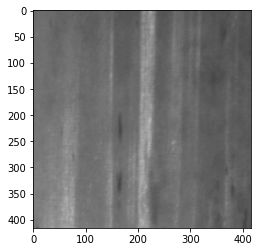

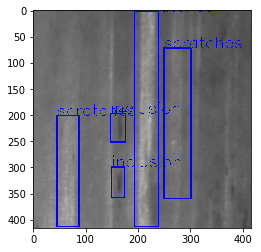

In [ ]:
# 查看读取的数据
img,gt_bbox = next(train_dataloader())
img = img.numpy()[0]
gt_bbox = gt_bbox.numpy()[0]
print(img.shape)
img = np.transpose(img,(1,2,0))
h,w = img.shape[0:2]
img = 255*img  
img = img.astype(np.uint8)
img_  = img.copy()
print(img.shape)
print(np.max(img))
print('label：')
print(gt_bbox)
for label in gt_bbox:
    if(label[3]==0):
        break
    print(DEF_NAMES[int(label[0])]) # 获取类别信息
    pt1 = (int(label[1] * w - label[3] * w / 2), int(label[2] * h - label[4] * h / 2)) # 根据x,y,w,h，转换得到真实框的左上角点
    pt2 = (int(label[1] * w + label[3] * w / 2), int(label[2] * h + label[4] * h / 2)) # 根据x,y,w,h，转换得到真实框的右下角点
    cv2.rectangle(img_,pt1,pt2,(0,0,255),2)  # 画框
    cv2.putText(img_,DEF_NAMES[int(label[0])],pt1,cv2.FONT_HERSHEY_SIMPLEX,1,(0,0,255))
plt.imshow(img)
plt.show()
plt.imshow(img_)
plt.show()

# 定义损失函数

**YOLOv2的论文中并未提到损失函数，这直接增大了网络训练难度。通过查阅资料和参考源码，可以了解到损失函数。**

**下面关于YOLOv2的损失函数的分析参考了：[YOLOv2解析](https://towardsdatascience.com/training-object-detection-yolov2-from-scratch-using-cyclic-learning-rates-b3364f7e4755)，[YOLOv2官方源码](https://github.com/pjreddie/darknet/blob/master/src/region_layer.c)，以及[YOLO v2 损失函数源码分析](https://www.cnblogs.com/YiXiaoZhou/p/7429481.html)**

**YOLOv2的损失函数可以由如下图所示：**

![](https://ai-studio-static-online.cdn.bcebos.com/fcf0075867ec4f9aaf1fac8c3f68c5964136a6e1688447ea920fbca14f655075)

**上图中权重，参照源码中的[cfg文件](https://github.com/pjreddie/darknet/blob/master/cfg/yolov2.cfg)，λnoobj=1，λobj=5，λcoord=1，λclass=1.**



In [10]:
# get_label函数获取用于计算损失的标志
from utils import get_label

# 计算loss函数
def getloss(pred, gt_bboxs, anchors, step_less_12800=False, num_classes=6,iou_threshold=0.6,object_scale=5,noobject_scale=1,class_scale=1,coord_scale=1,rescore = True):
    '''
    pres：网络输出，数据格式为[batchsize,num_anchors*(num_classes+5), 13, 13]的tensor
    gt_bboxs：
    rescore： 为True，表示置信度标签为预测框与真实框之间的iou值，为False，标志置信度为1.
    '''
    assert pred.shape[0]==gt_bboxs.shape[0], 'pred.shape[0] should be equal to gt_bboxs.shape[0], but receive {}!={}'.format(pred.shape[0],gt_bboxs.shape[0])
    
    b,_,h,w = pred.shape # h = w = 13
    _,nums, c = gt_bboxs.shape
    num_anchors = len(anchors)//2 # num_anchors = 5
    
    # 调用get_label()函数
    label_objectness_confidence,label_location,label_classification,scale_location,object_mask,noobject_mask = get_label(pred,gt_bboxs,anchors,iou_threshold,
                                                                                                                        step_less_12800,num_classes,rescore = True)

    reshaped_pred = paddle.reshape(pred, [b, num_anchors, num_classes+5, pred.shape[2], pred.shape[3]])
    reshaped_pred = paddle.transpose(reshaped_pred,perm=[0, 3, 4, 1, 2])

    # 置信度  sigmoid(t0)
    pred_objectness_confidence = paddle.nn.functional.sigmoid(reshaped_pred[:, :, :, :, 4]) 
    # 获取与位置相关的预测值 tx,ty,tw,th
    tx = paddle.nn.functional.sigmoid(reshaped_pred[:, :, :, :, 0])
    ty = paddle.nn.functional.sigmoid(reshaped_pred[:, :, :, :, 1])
    tw = reshaped_pred[:, :, :, :, 2]
    th = reshaped_pred[:, :, :, :, 3]
    # 与类别概率相关的预测值
    pred_classification = paddle.nn.functional.softmax(reshaped_pred[:, :, :, :, 5:5+num_classes]) 

    # 从label_location中取出各个位置坐标的标签
    dx_label = label_location[:, :, :, :, 0]
    dy_label = label_location[:, :, :, :, 1]
    tw_label = label_location[:, :, :, :, 2]
    th_label = label_location[:, :, :, :, 3]

    # 计算置信度损失, mse损失
    loss_objectness_confidence = paddle.nn.functional.mse_loss(pred_objectness_confidence, label_objectness_confidence, reduction='none')
    
    # 总置信度损失等于无目标置信度损失加有目标置信度损失
    loss_objectness = object_scale*object_mask*loss_objectness_confidence + noobject_scale*noobject_mask*loss_objectness_confidence

    # 计算位置损失，mse损失
    loss_location_x = paddle.nn.functional.mse_loss(tx, dx_label,reduction='none')
    loss_location_y = paddle.nn.functional.mse_loss(ty, dy_label,reduction='none')
    loss_location_w = paddle.nn.functional.mse_loss(tw, tw_label,reduction='none')
    loss_location_h = paddle.nn.functional.mse_loss(th, th_label,reduction='none')
    loss_location = loss_location_x+loss_location_y+loss_location_w+loss_location_h 
    if(step_less_12800):
        loss_location = scale_location * loss_location  # 对于负责预测目标的预测框，权值系数为2.0 - gt_w * gt_h , 其他预测框的权重系数为0.01
    else:
        loss_location = scale_location * loss_location
        loss_location = object_mask * loss_location   # 只计算预测框内有目标的情况

    # 计算类别损失，mse损失
    loss_classification = paddle.nn.functional.mse_loss(pred_classification, label_classification,reduction='none') 
    loss_classification = paddle.sum(loss_classification, axis=-1) # 原来loss_classification的shape为(batchsize, 13, 13，num_anchors, num_classes)
                                                                  # 求和后loss_classification的shape为(batchsize, 13, 13，num_anchors)
    loss_classification = object_mask*loss_classification # 只计算预测框内有目标的情况

    total_loss = loss_objectness + coord_scale*loss_location + class_scale*loss_classification
    # 对所有预测框的loss进行求和
    total_loss = paddle.sum(total_loss, axis=[1,2,3])
    # 对所有样本求平均
    total_loss = paddle.mean(total_loss)
    return total_loss

# 训练

**加载了预训练模型**

**保存一个最后模型与一个best模型，最后保存的best模型训练损失为6.0688148。。。。**

![](https://ai-studio-static-online.cdn.bcebos.com/abfc002ec63142269996fe72404145cee88a5bfd9bf043bface1fc81fab79fb3)


In [ ]:
from visualdl import LogWriter

if __name__ == '__main__':  
    epoch = 100
    batchsize =32
    lr = 0.001
    lowest_loss = 6.0688148
    best_epoch = 0
    train_step = 0

    num_classes = 6
    iou_threshold=0.6
    anchor = [1.43,2.86, 3.77,4.615, 8.97,4.03, 2.015,11.245, 6.695,11.83] 
    object_scale=5
    noobject_scale=1
    class_scale=1
    coord_scale=1

    train_dataset = def_data_reader(name_path='work/defectData/NEU-DET/train.txt')
    train_dataloader = DataLoader(train_dataset,batch_size=batchsize,shuffle =True,drop_last=True)
    # val_dataset = def_data_reader(name_path='work/defectData/NEU-DET/vali.txt',is_train=False)
    # val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False,drop_last=False)

    model = YOLOv2()
    state_dict = paddle.load('work/models/best.pdparams') # 加载预训练模型
    model.set_state_dict(state_dict) # 加载预训练模型
    # optimizer = paddle.optimizer.Momentum(learning_rate=lr, momentum=0.9,parameters=model.parameters(),weight_decay=0.0005)
    optimizer = paddle.optimizer.SGD(learning_rate = lr,parameters = model.parameters(), weight_decay=0.0005)

    writer = LogWriter(logdir="./log/train") # 初始化一个记录器
    for e in range(epoch):
        #训练
        model.train()
        loss1 = paddle.to_tensor([0.0]) # 记录训练时的损失
        loss2 = paddle.to_tensor([0.0]) # 记录验证时的损失
        avg_loss = 0.0
        for i,(inputs,gt_bboxs) in enumerate(train_dataloader):
            pred = model(inputs)
            loss = getloss(pred, gt_bboxs, anchor, step_less_12800= False,num_classes=num_classes,iou_threshold=iou_threshold,
                           object_scale=object_scale,noobject_scale=noobject_scale,class_scale=class_scale,coord_scale=coord_scale,rescore = True) # train_step<12800
            optimizer.clear_grad()
            loss.backward()
            optimizer.step()
            loss1 = loss1 + loss
            if i % 10 == 0:  # 每10步输出一次
                timestring = time.strftime("%Y-%m-%d %H:%M:%S",time.localtime(time.time()))
                print('{}[TRAIN]Epoch {}/{}| iter {}/{}| Loss: {}'.format(timestring, e,epoch,i,len(train_dataloader),loss.numpy()))
                print('lr：{}'.format(optimizer.get_lr()))
                # print("Epoch %d/%d| Step %d/%d| Loss: %.2f"%(e,epoch,i,len(train_dataloader),loss))
            train_step = train_step+1 # 更新训练步数
        avg_loss = loss1/len(train_dataloader) # 计算一个epoch的平均损失
        writer.add_scalar(tag="train_loss", step=e, value=avg_loss)

        if (e+1)%10==0:
            paddle.save(model.state_dict(),"work/models/last.pdparams") # 
        if (e+1)>20:
            if lowest_loss>avg_loss:
                lowest_loss = avg_loss
                best_epoch = e
                paddle.save(model.state_dict(),"work/models/best.pdparams") # 保存最好的模型
            print("best model is saved  at Epoch {}/{}, lowest_loss is {}".format(best_epoch,epoch,lowest_loss.numpy()))
    paddle.save(model.state_dict(),"work/models/last.pdparams")

# 效果可视化
没有写网络验证函数。。

In [11]:
model = YOLOv2()
state_dict = paddle.load('work/models/best.pdparams')
model.set_state_dict(state_dict)

In [12]:
COLOR = [(255,0,0),(255,125,0),(255,255,0),(255,0,125),(255,0,250),(255,125,125)]

In [13]:
from utils import get_yolo_box_xxyy
from postprocess import postprocess

In [14]:
vali_dataset = def_data_reader(name_path='work/defectData/NEU-DET/vali.txt',is_train=False)
vali_dataloader = DataLoader(vali_dataset,batch_size=1,shuffle =True,drop_last=True)

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data.dtype == np.object:
/home/aistudio/postprocess.py:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  keep = np.zeros(len(pred_box), dtype=np

label：
scratches
predict：
scratches


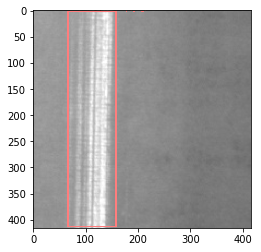

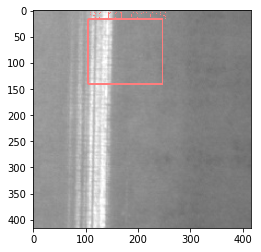

In [17]:
inputs,gt_bboxs = next(vali_dataloader())

model.eval()
pred = model(inputs)
pred_box = get_yolo_box_xxyy(pred, anchor, num_classes=6)
pred_box = pred_box.squeeze(axis = 0)
pred_box = paddle.reshape(pred_box,[-1,4])

reshaped_pred = paddle.reshape(pred, [-1, 5, 6+5, pred.shape[2], pred.shape[3]])
reshaped_pred = paddle.transpose(reshaped_pred,perm=[0, 3, 4, 1, 2])

# 置信度  sigmoid(t0)
pred_objectness_confidence = paddle.nn.functional.sigmoid(reshaped_pred[:, :, :, :, 4])[0] 
pred_objectness_confidence = paddle.unsqueeze(pred_objectness_confidence,axis=3)

# 与类别概率相关的预测值
pred_classification = paddle.nn.functional.softmax(reshaped_pred[:, :, :, :, 5:5+6])[0]

score = pred_classification*pred_objectness_confidence # 分数为置信度乘以类别概率
score = paddle.reshape(score,[-1,6])
pred_box = pred_box.numpy()
score = score.numpy()

pred_box,score,cls_inds = postprocess(pred_box,score,conf_thresh = 0.004)

inputs = inputs.squeeze(axis=0)  # 输入图像的尺寸是(1,3,448,448),压缩为(3,448,448)
inputs = paddle.transpose(inputs, perm=(1,2,0))  # 转换为(448,448,3)
img = inputs.numpy()
img = 255*img  
img = img.astype(np.uint8)
img_  = img.copy()
gt_bboxs = gt_bboxs.numpy()[0]
print('label：')
for label in gt_bboxs:
    if(label[3]==0):
        break
    print(DEF_NAMES[int(label[0])]) # 获取类别信息
    pt1 = (int(label[1] * 416 - label[3] * 416 / 2), int(label[2] * 416 - label[4] * 416 / 2)) # 根据x,y,w,h，转换得到真实框的左上角点
    pt2 = (int(label[1] * 416 + label[3] * 416 / 2), int(label[2] * 416 + label[4] * 416 / 2)) # 根据x,y,w,h，转换得到真实框的右下角点
    cv2.rectangle(img_,pt1,pt2,COLOR[int(label[0])],2)  # 画框
    cv2.putText(img_,DEF_NAMES[int(label[0])],pt1,cv2.FONT_HERSHEY_SIMPLEX,1,COLOR[int(label[0])])
plt.imshow(img_)
plt.show()

img_  = img.copy()
print('predict：')
for i, label in enumerate(pred_box):
    print(DEF_NAMES[int(cls_inds[i])]) 
    pt1 = (int(label[0]*416), int(label[1]*416)) 
    pt2 = (int(label[2]*416), int(label[3]*416)) 
    cv2.rectangle(img_,pt1,pt2,COLOR[int(cls_inds[i])],2)  # 画框
    cv2.putText(img_,DEF_NAMES[int(cls_inds[i])],pt1,cv2.FONT_HERSHEY_SIMPLEX,1,COLOR[int(cls_inds[i])])
plt.imshow(img_)
plt.show()

# 总结与收获

结合[AI达人创造营](https://aistudio.baidu.com/aistudio/education/group/info/24607)的学习内容，了解项目产生的完整流程，并实践，一个学习记录。。

模型的训练效果不够好，网络搭建与训练过程中，没有涉及到论文中的许多细节。**同时，缺陷特征不是很明显，而且不同的缺陷有些相似，在利用深度学习网络检测时，应该要充分利用低层信息**。但是YOLOv2网络中，只有一个passthrough层，将高分辨率特征与低分辨率特征在通道上进行叠加，未充分利用低层特征信息，这应该也是网络检测效果较差的原因之一。



从网络搭建，anchor设计，获取标签，到损失函数计算，记录学习过程，进一步理解了YOLO检测网络设计思想。

使用开发的套件[PaddleDetection](https://github.com/PaddlePaddle/PaddleDetection)，效果要好（废话）：
![](https://ai-studio-static-online.cdn.bcebos.com/c664d2c2b69f4872aedb79645624238cdfc750df47c041ed9301d59597b9fafd)


